In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml
from copy import deepcopy

from n3jet.utils import FKSPartition
from n3jet.utils.general_utils import (
    bool_convert,
    dot
)


Bad key "legend.title_fontsize" on line 22 in
/mt/home/jbullock/.config/matplotlib/stylelib/notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# original NJet to compare against
nj_compare_dir = '/mt/batch/jbullock/Sherpa_NJet/runs/diphoton/3g2A/RAMBO/parallel_fixed/integration_grid/NJet_NJet_unit_grid_5_seed_reweight/'
hepmc_mom_file_nj_compare = nj_compare_dir + 'full_momenta_events_3M_new_sherpa_cuts_PDF.npy'
events_file_nj_compare = nj_compare_dir + 'original_weights_events_3M_new_sherpa_cuts_PDF.npy'
trials_file_nj_compare = nj_compare_dir + 'trials_events_3M_new_sherpa_cuts_PDF.npy'

# NN files for reweighting
nn_dir = '/mt/batch/jbullock/Sherpa_NJet/runs/diphoton/3g2A/RAMBO/parallel_fixed/integration_grid/nn_NJet_unit_grid_30_seed_reweight/'
hepmc_mom_file_nn = nn_dir + 'full_momenta_events_3M_new_sherpa_cuts_PDF.npy'
events_file_nn = nn_dir + 'original_weights_events_3M_new_sherpa_cuts_PDF.npy'
trials_file_nn = nn_dir + 'trials_events_3M_new_sherpa_cuts_PDF.npy'

# NJet file used to reweight
nj_dir = '/mt/batch/jbullock/Sherpa_NJet/runs/diphoton/3g2A/RAMBO/parallel_fixed/integration_grid/NJet_NJet_unit_grid_30_seed/'
hepmc_mom_file_nj = nj_dir + 'full_momenta_events_3M_new_sherpa_cuts_PDF.npy'
events_file_nj = nj_dir + 'original_weights_events_3M_new_sherpa_cuts_PDF.npy'
trials_file_nj = nj_dir + 'trials_events_3M_new_sherpa_cuts_PDF.npy'

In [3]:
nn_yaml_file = '/mt/home/jbullock/n3jet/n3jet/runs/runs/diphoton/3g2A/RAMBO/parallel_fixed/fks_all_legs_all_pairs_new_sherpa_cuts_pdf_njet.yaml'

In [4]:
with open(nn_yaml_file) as f:
    y = yaml.load(f, Loader=yaml.FullLoader)
    
all_legs = bool_convert(y["all_legs"])
delta_cut = y["delta_cut"]
delta_near = y["delta_near"]

In [5]:
def len_check(x):
    if x is None:
        raise ValueError('Value is None')
    elif len(x) > 1:
        raise ValueError('length of array is > 1')
    elif len(x) < 1:
        raise ValueError('length of array is < 1')
    else:
        return x[0]
    
def reconcile(to_match, match_to):
    indices = []
    for idx, i in tqdm(enumerate(to_match)):
        try_all = np.where(np.all(match_to==i, axis=(1, 2)))[0]
        if len(try_all) == 0:
            try_2 = np.where(np.all(match_to[:,2]==i[2], axis=(1)))[0]
            if len(try_2) == 0:
                try_3 = np.where(np.all(match_to[:,3]==i[3], axis=(1)))[0]
                if len(try_3) == 0:
                    try_4 = np.where(np.all(match_to[:,4]==i[4], axis=(1)))[0]
                    if len(try_4) == 0:
                        print ('Struggling on index: {}'.format(idx))
                        indices.append(None)
                    else:
                        indices.append(try_4)
                else:
                    indices.append(try_3)
            else:
                indices.append(try_2)
        else:
            indices.append(try_all)
    return indices

def index_process(x):
    indices = []
    for i in tqdm(x):
        index = len_check(i)
        indices.append(index)
        
    return indices

## Load data

In [6]:
hepmc_mom_nj_compare = np.load(hepmc_mom_file_nj_compare, allow_pickle=True)
events_nj_compare = np.load(events_file_nj_compare, allow_pickle=True)
trials_nj_compare = np.load(trials_file_nj_compare, allow_pickle=True)

hepmc_mom_nn = np.load(hepmc_mom_file_nn, allow_pickle=True)
events_nn = np.load(events_file_nn, allow_pickle=True)
trials_nn = np.load(trials_file_nn, allow_pickle=True)

hepmc_mom_nj = np.load(hepmc_mom_file_nj, allow_pickle=True)
events_nj = np.load(events_file_nj, allow_pickle=True)
trials_nj = np.load(trials_file_nj, allow_pickle=True)

In [7]:
assert np.sum(trials_nn) == np.sum(trials_nj)

## Split data

In [8]:
nn_fks_partition = FKSPartition(
    momenta = list(hepmc_mom_nn),
    labels = events_nn,
    all_legs = all_legs
)

nn_cut_momenta, nn_near_momenta, nn_cut_labels, nn_near_labels = nn_fks_partition.cut_near_split(
    delta_cut = delta_cut,
    delta_near = delta_near
)

100%|██████████| 3000000/3000000 [01:50<00:00, 27167.12it/s]


In [9]:
nj_fks_partition = FKSPartition(
    momenta = list(hepmc_mom_nj),
    labels = events_nj,
    all_legs = all_legs
)

nj_cut_momenta, nj_near_momenta, nj_cut_labels, nj_near_labels = nj_fks_partition.cut_near_split(
    delta_cut = delta_cut,
    delta_near = delta_near
)

100%|██████████| 3000000/3000000 [01:59<00:00, 25187.57it/s]


In [10]:
nn_near_round = np.round(nn_near_momenta, 6)
nj_near_round = np.round(nj_near_momenta, 6)

## Cross-section check

In [11]:
xs_compare = np.sum(events_nj_compare)/np.sum(trials_nj_compare)
print ("Comparison XS is {}".format(xs_compare))

Comparison XS is 4.16388398332e-06


In [12]:
nn_xs = np.sum(events_nn)/np.sum(trials_nn)
print ("NN XS is {}".format(nn_xs)) 

NN XS is 4.18056666517e-06


In [13]:
nj_xs = np.sum(events_nj)/np.sum(trials_nj)
print ("NJ XS is {}".format(nj_xs)) 

NJ XS is 4.15915685358e-06


In [28]:
f = np.sum(events_nj)/np.sum(trials_nj)
f_2 = np.sum(events_nj**2)/np.sum(trials_nj)
nj_xs_std = np.sqrt((f_2-f**2)/np.sum(trials_nj))

In [29]:
nj_xs_std

8.457771070598585e-09

## Reweight

In [14]:
reweight_props = np.arange(0,1.1,0.1)

In [15]:
chosen_max = np.random.randint(0,len(nn_near_round), int(np.max(reweight_props)*len(nn_near_round)))

In [16]:
nn_near_chosen = nn_near_round[chosen_max]

In [17]:
nn_near_chosen[0]

array([[184.789495,   0.      ,   0.      , 184.789495],
       [ 52.523328,   0.      ,   0.      , -52.523328],
       [ 45.5356  ,  11.200946,   5.905134,  43.739673],
       [ 97.009368,  59.170231, -57.287987,  51.261952],
       [ 94.767855, -70.371178,  51.382853,  37.264542]])

In [18]:
nj_indices = reconcile(nn_near_chosen, nj_near_round)

264228it [49:14, 89.44it/s]


In [19]:
assert len(nj_indices) == len(chosen_max)

In [20]:
nj_indices = index_process(nj_indices)

100%|██████████| 264228/264228 [00:00<00:00, 869811.89it/s]


In [21]:
nn_near_labels_reweights = []
for i in reweight_props:
    nn_near_labels_new = deepcopy(nn_near_labels)
    for jdx, j in enumerate(chosen_max[:int(i*len(nn_near_labels_new))]):
        nn_near_labels_new[j] = nj_near_labels[nj_indices[jdx]]
    nn_near_labels_reweights.append(nn_near_labels_new)

In [22]:
nn_xs_reweights = []
for i in nn_near_labels_reweights:
    new_xs = np.sum(np.concatenate((nn_cut_labels, i)))/np.sum(trials_nn)
    nn_xs_reweights.append(new_xs)
    print ("New XS is {}".format(new_xs))

New XS is 4.18056666517e-06
New XS is 4.17560691606e-06
New XS is 4.17241299469e-06
New XS is 4.16802748609e-06
New XS is 4.16596987317e-06
New XS is 4.16201199483e-06
New XS is 4.15810100005e-06
New XS is 4.15492321473e-06
New XS is 4.15185458781e-06
New XS is 4.14925340872e-06
New XS is 4.14748982456e-06


In [23]:
nn_xs_reweights = np.array(nn_xs_reweights)

## Plot convergence

In [24]:
#nj_xs_std = 3.861174e-08

In [25]:
#nj_xs = 4.138093e-06

In [30]:
nj_xs_std/nj_xs

0.0020335302005532385

In [38]:
reweight_index = 6

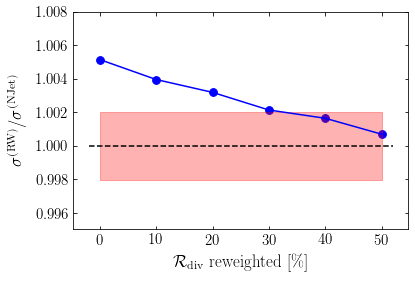

In [41]:
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

plt.scatter(np.array(reweight_props[:reweight_index])*100, nn_xs_reweights[:reweight_index]/nj_xs, color="blue", s=60)
plt.plot(np.array(reweight_props[:reweight_index])*100, nn_xs_reweights[:reweight_index]/nj_xs, color="blue")
plt.hlines(1.,-2,52, linestyles='--')
plt.fill_between(np.array(reweight_props[:reweight_index])*100, 1-nj_xs_std/nj_xs, 1+nj_xs_std/nj_xs, color="red", alpha=0.3)

plt.tick_params(axis='x', labelsize=15, direction = 'in', top = True, which='both')
plt.tick_params(axis='y', labelsize=15, direction = 'in', right = True, which='both')

plt.ylim((0.995,1.008))
plt.xlabel(r'$\mathcal{R}_{\mathrm{div}}$ reweighted [\%]', fontsize=17, labelpad=10)
plt.ylabel(r'$\sigma^{\mathrm{(RW)}}/\sigma^{\mathrm{(NJet)}}$', fontsize=17, labelpad=10)

plt.savefig('./paper_plots/5_point/100k_unit_reweighting.pdf', dpi=150, bbox_inches='tight')
plt.show()